<a href="https://colab.research.google.com/github/ibombonato/aicrowd-blitz-faceimages/blob/main/AiCrowd_Tabular_Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



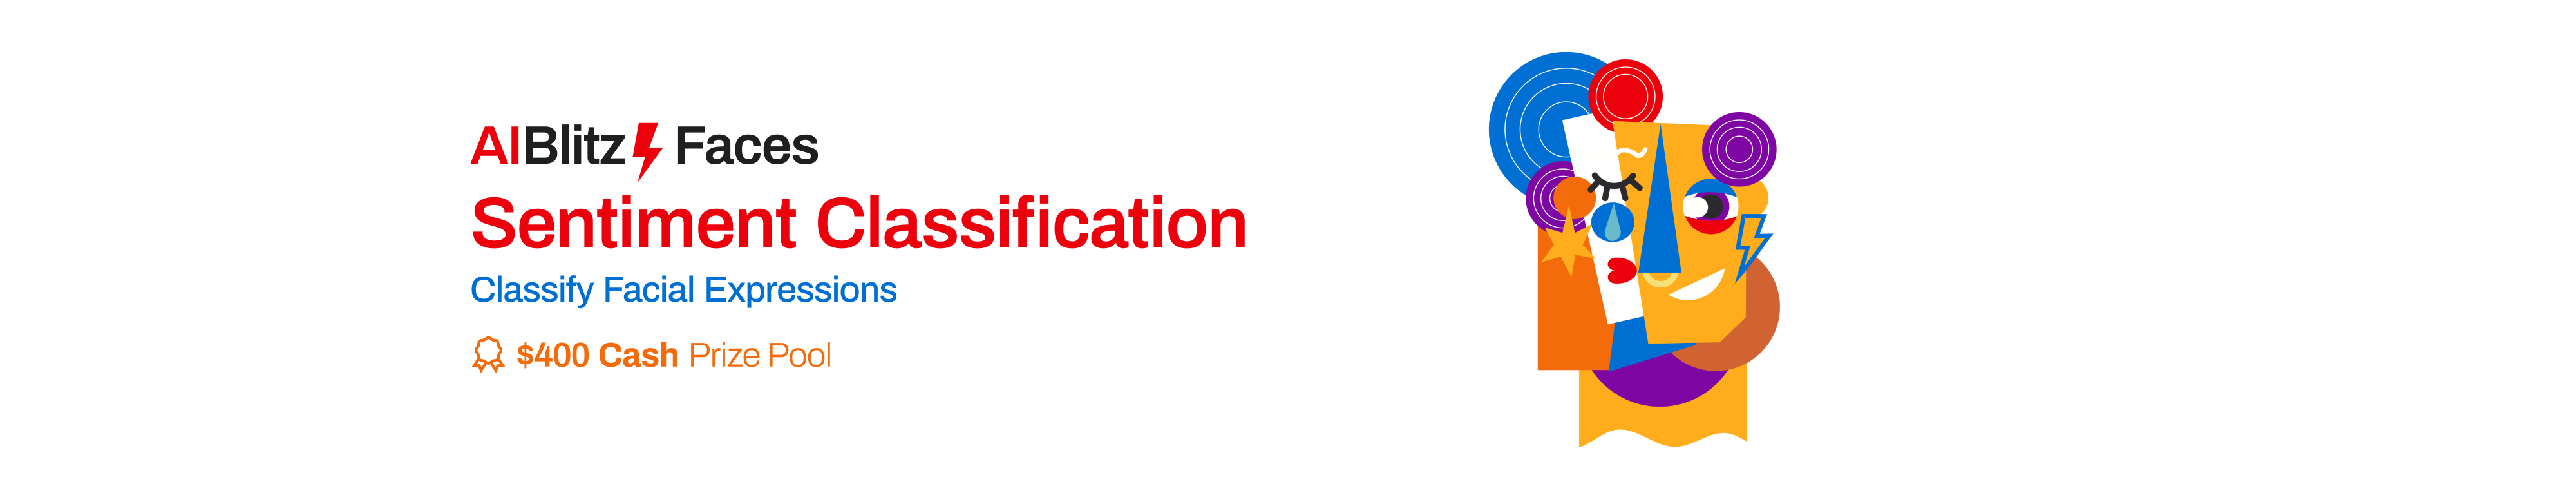

<h2><center> Getting Started with Sentiment Classification</center></h2>

In this puzzle, we have to classify the sentiment into 3 classes, positive, negative and neutral from the given features of an human face. 

This is a starter kit explaining how to download the data and also submit direcly via this notebook. 

We will be submitting the sample prediction directly in the required format.





# Download the files 💾¶
## Download AIcrowd CLI

We will first install aicrowd-cli which will help you download and later make submission directly via the notebook.


In [ ]:
!pip install aicrowd-cli

In [ ]:
!pip install --upgrade fastai
!pip install pyjanitor
!pip install bayesian-optimization
!pip install catboost
!pip install pytorch-tabnet fast_tabnet

In [1]:
import fastai
fastai.__version__

'2.5.3'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## Login to AIcrowd ㊗¶


In [3]:
%load_ext aicrowd.magic
%aicrowd login

Please login here: https://api.aicrowd.com/auth/vtiKQLRG41YY0pYe311YXOzb3Hdb5e-KGLuxKRbicwg
API Key valid
Gitlab access token valid
Saved details successfully!



## Download Dataset¶

We will create a folder name data and download the files there.


In [4]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c sentiment-classification -o data

sample_submission.csv:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/51.5M [00:00<?, ?B/s]

val.csv:   0%|          | 0.00/20.6M [00:00<?, ?B/s]

## Importing Libraries:

In [5]:
import pandas as pd
import numpy as np
import os
from ast import literal_eval
from fastai.tabular.all import *
import janitor

## Diving in the dataset 🕵️‍♂️

In [6]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")

In [7]:
test_df = pd.read_csv("data/test.csv")

In [8]:
def make_df(df):
  X = [literal_eval(embedding) for embedding in df['embeddings'].values]
  df_new = pd.DataFrame(X)
  if 'label' in df.columns:
    df_new['label'] = df['label'].values

  return df_new.clean_names()

In [9]:
df_train = make_df(train_df)
df_val = make_df(val_df)
df_test = make_df(test_df)

In [10]:
df_train['is_valid'] = False
df_val['is_valid'] = True

In [11]:
df_all = pd.concat([df_train, df_val])

## Optim

In [24]:
accuracy_score([le_scaler.classes_[item.argmax()] for item in svm_preds], le_scaler.inverse_transform(Y_val_scaled))from bayes_opt import BayesianOptimization

def fit_with(lr:float, wd:float, dp:float, n_layers:float, layer_1:float, layer_2:float, layer_3:float):

    print(lr, wd, dp)
    if round(n_layers) == 2:
        layers = [round(layer_1), round(layer_2)]
    elif int(n_layers) == 3:
        layers = [round(layer_1), round(layer_2), round(layer_3)]
    else:
        layers = [round(layer_1)]
    config = tabular_config(embed_p=float(dp),
                          ps=float(wd))
    learn = tabular_learner(dls, layers=layers, metrics=accuracy, config = config)

    with learn.no_bar() and learn.no_logging():
        learn.fit(5, lr=float(lr))

    acc = float(learn.validate()[1])

    return acc

## Training FastAI

In [25]:
splits = ColSplitter()(df_all)

In [26]:
to = TabularPandas(df_all, 
                   procs=[Normalize],
                   cont_names = list(map(str, np.arange(1,512))),
                   y_names='label',
                   y_block = CategoryBlock(),
                   splits=splits,
                   )

In [27]:
dls = to.dataloaders(bs=512)

In [28]:
hps = {'lr': (1e-05, 1e-01),
      'wd': (4e-4, 0.4),
      'dp': (0.01, 0.5),
       'n_layers': (1,3),
       'layer_1': (50, 200),
       'layer_2': (100, 1000),
       'layer_3': (200, 2000)}

In [29]:
optim = BayesianOptimization(
    f = fit_with, # our fit function
    pbounds = hps, # our hyper parameters to tune
    verbose = 2, # 1 prints out when a maximum is observed, 0 for silent
    random_state=1
)

In [30]:
%time optim.maximize(n_iter=20)

|   iter    |  target   |    dp     |  layer_1  |  layer_2  |  layer_3  |    lr     | n_layers  |    wd     |
-------------------------------------------------------------------------------------------------------------
0.014684121522803134 0.07482958046651729 0.21434078230426126


|  1        |  0.7815   |  0.2143   |  158.0    |  100.1    |  744.2    |  0.01468  |  1.185    |  0.07483  |
0.06852509784467198 0.3512957275818218 0.1793247562510934


|  2        |  0.7735   |  0.1793   |  109.5    |  584.9    |  954.6    |  0.06853  |  1.409    |  0.3513   |
0.014047289990137426 0.32037752964274446 0.02341992066698382


|  3        |  0.7755   |  0.02342  |  150.6    |  475.6    |  1.206e+0 |  0.01405  |  1.396    |  0.3204   |
0.0894617202837497 0.016006291379859792 0.4844481721025048


|  4        |  0.758    |  0.4844   |  97.01    |  723.1    |  1.778e+0 |  0.08946  |  1.17     |  0.01601  |
0.0957893741197487 0.27687409473460917 0.09321690558663875


|  5        |  0.757    |  0.09322  |  181.7    |  188.5    |  958.0    |  0.09579  |  2.066    |  0.2769   |
0.09979808009825568 0.018916516025050015 0.36477578863998344


|  6        |  0.757    |  0.3648   |  160.9    |  483.1    |  1.197e+0 |  0.0998   |  2.64     |  0.01892  |
0.06871704593431362 0.08108907855876547 0.38494126892841346


|  7        |  0.774    |  0.3849   |  66.43    |  569.8    |  1.583e+0 |  0.06872  |  1.266    |  0.08109  |
0.057910440131609765 0.16129406478624328 0.4828208474809104


|  8        |  0.773    |  0.4828   |  59.94    |  147.0    |  1.301e+0 |  0.05791  |  2.722    |  0.1613   |
0.06825546229572553 0.38961448701474927 0.16830582168120725


|  9        |  0.767    |  0.1683   |  156.9    |  531.9    |  248.2    |  0.06826  |  2.559    |  0.3896   |
0.0002796637130848967 0.0448370970701597 0.22630281827604312


|  10       |  0.733    |  0.2263   |  126.3    |  625.4    |  1.711e+0 |  0.000279 |  2.636    |  0.04484  |
0.06552505896942336 0.08103743930918762 0.36112697236765107


|  11       |  0.761    |  0.3611   |  147.7    |  194.1    |  356.8    |  0.06553  |  2.663    |  0.08104  |
0.0005465734116890944 0.17802142541867974 0.46329843491833883


|  12       |  0.7595   |  0.4633   |  175.7    |  106.8    |  1.81e+03 |  0.000546 |  2.017    |  0.178    |
0.0404514572663943 0.31234441498440596 0.4911455437346324


|  13       |  0.748    |  0.4911   |  79.71    |  936.3    |  947.6    |  0.04045  |  1.032    |  0.3123   |
0.029415674202259722 0.005868544291961274 0.31814795484259445


|  14       |  0.7935   |  0.3181   |  174.3    |  660.7    |  794.0    |  0.02942  |  1.182    |  0.005869 |
0.09277135723767846 0.23871276504022906 0.23800477408617662


|  15       |  0.7515   |  0.238    |  85.34    |  272.8    |  374.2    |  0.09277  |  1.858    |  0.2387   |
0.08587444516476887 0.28296146998636684 0.41475477052068255


|  16       |  0.7565   |  0.4148   |  166.6    |  745.6    |  1.552e+0 |  0.08587  |  1.014    |  0.283    |
0.05980585297097031 0.13840005586279047 0.4156342008016683


|  17       |  0.7495   |  0.4156   |  138.7    |  652.3    |  1.189e+0 |  0.05981  |  2.277    |  0.1384   |
0.01267543972161491 0.031847546491466955 0.07713340655002433


|  18       |  0.7605   |  0.07713  |  199.0    |  370.6    |  1.418e+0 |  0.01268  |  2.443    |  0.03185  |
0.03371097825906736 0.24308187833868272 0.30397868846063675


|  19       |  0.7715   |  0.304    |  88.75    |  865.5    |  1.158e+0 |  0.03371  |  2.742    |  0.2431   |
0.06812203079874606 0.15231331799775338 0.019302961235447946


|  20       |  0.7495   |  0.0193   |  179.4    |  484.5    |  552.1    |  0.06812  |  1.828    |  0.1523   |
0.0901579115596612 0.3257604080789177 0.1262146004249747


|  21       |  0.741    |  0.1262   |  121.4    |  354.0    |  1.906e+0 |  0.09016  |  2.733    |  0.3258   |
0.0068606341422042605 0.2836385486024702 0.2324294141913902


|  22       |  0.784    |  0.2324   |  180.7    |  502.4    |  353.3    |  0.006861 |  2.457    |  0.2836   |
0.09434439277229052 0.21203901509994721 0.13849929353109322


|  23       |  0.7605   |  0.1385   |  112.9    |  396.5    |  469.1    |  0.09434  |  1.168    |  0.212    |
0.0013452122952142835 0.2484013303440626 0.2875627294840168


|  24       |  0.7805   |  0.2876   |  137.1    |  555.9    |  1.326e+0 |  0.001345 |  1.521    |  0.2484   |
0.06689150886870916 0.34717466736852354 0.48250677755680693


|  25       |  0.758    |  0.4825   |  63.87    |  702.1    |  1.68e+03 |  0.06689  |  2.081    |  0.3472   |
CPU times: user 40.1 s, sys: 3.69 s, total: 43.8 s
Wall time: 42.7 s


In [31]:
print(optim.max)

{'target': 0.7935000061988831, 'params': {'dp': 0.31814795484259445, 'layer_1': 174.2945076495272, 'layer_2': 660.7024289136516, 'layer_3': 793.9900876749765, 'lr': 0.029415674202259722, 'n_layers': 1.1819996458200757, 'wd': 0.005868544291961274}}


In [32]:
config = tabular_config(embed_p=float(optim.max['params']['dp']),
                          ps=float(optim.max['params']['wd']))
learn = tabular_learner(dls, layers = [67], metrics=accuracy, config = config)

In [33]:
learn.fine_tune(500, float(optim.max['params']['lr']), wd = float(optim.max['params']['wd']))

epoch,train_loss,valid_loss,accuracy,time
0,0.776722,0.729920,0.710000,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.521485,0.573015,0.750500,00:00
1,0.478994,0.532632,0.773500,00:00
2,0.446150,0.519516,0.770500,00:00
3,0.415391,0.520582,0.776500,00:00
4,0.387029,0.528473,0.775500,00:00
5,0.358263,0.524680,0.774500,00:00
6,0.331120,0.534240,0.772000,00:00
7,0.303934,0.540985,0.778500,00:00
8,0.278140,0.555147,0.776000,00:00
9,0.251548,0.577093,0.774500,00:00


## Training XGBoost

In [34]:
seed = 112 # Random seed
import sklearn.metrics as skm
import xgboost as xgb

def xgbc_cv(max_depth,learning_rate,n_estimators,reg_alpha, colsample_bytree, gamma, min_child_weight):   
    estimator_function = xgb.XGBClassifier(
                                        max_depth=int(max_depth),
                                        colsample_bytree= colsample_bytree,
                                        gamma=gamma,
                                        min_child_weight= int(min_child_weight),
                                        learning_rate= learning_rate,
                                        n_estimators= int(n_estimators),
                                        reg_alpha = reg_alpha,
                                        nthread = -1,
                                        objective='multi:softmax',
                                        #objective='binary:logistic',
                                        #subsample=subsample,
                                        seed = seed)
    # Fit the estimator
    estimator_function.fit(X_train,y_train)
    
    # calculate out-of-the-box roc_score using validation set 1
    probs = estimator_function.predict_proba(X_val)
    
    val = skm.accuracy_score([estimator_function.classes_[item.argmax()] for item in probs], y_val)
        
    # return the mean validation score to be maximized 
    return np.array([val]).mean()

In [13]:
X_train, y_train = df_train.iloc[:,0:512].to_numpy(), df_train['label'].to_numpy()
X_val, y_val = df_val.iloc[:,0:512].to_numpy(), df_val['label'].to_numpy()
X_test = df_test.iloc[:,0:512].to_numpy()

In [35]:
gp_params = {"alpha": 1e-10}

# We create the BayesianOptimization objects using the functions that utilize
# the respective classifiers and return cross-validated scores to be optimized.

seed = 112 # Random seed

# We create the bayes_opt object and pass the function to be maximized
# together with the parameters names and their bounds.
# Note the syntax of bayes_opt package: bounds of hyperparameters are passed as two-tuples

hyperparameter_space = {
    'max_depth': (2, 10),
    'learning_rate': (0, 1),
    'n_estimators' : (10,200),
    'reg_alpha': (0,1),
    'min_child_weight': (1, 20),
    'colsample_bytree': (0.1, 1),
    'gamma' : (0,1),
    #'subsample': (0.2,0.9)
}

xgbcBO = BayesianOptimization(f = xgbc_cv, 
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)

# Finally we call .maximize method of the optimizer with the appropriate arguments
# kappa is a measure of 'aggressiveness' of the bayesian optimization process
# The algorithm will randomly choose 3 points to establish a 'prior', then will perform 
# 10 interations to maximize the value of estimator function
xgbcBO.maximize(init_points=2,n_iter=20,acq='ucb', kappa= 3, **gp_params)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.738    |  0.4376   |  0.6403   |  0.95     |  2.605    |  15.76    |  168.2    |  0.05481  |
|  2        |  0.7225   |  0.8359   |  0.8854   |  0.7223   |  2.02     |  19.64    |  75.25    |  0.09476  |
|  3        |  0.7255   |  0.8419   |  0.03895  |  0.2165   |  2.775    |  15.07    |  168.9    |  0.3362   |
|  4        |  0.7405   |  0.1502   |  0.5569   |  0.6168   |  2.511    |  16.08    |  150.8    |  0.924    |
|  5        |  0.717    |  0.5066   |  0.3194   |  0.5964   |  8.665    |  13.68    |  33.63    |  0.892    |
|  6        |  0.6935   |  0.2203   |  0.885    |  0.8635   |  8.071    |  12.41    |  31.79    |  0.7216   |
|  7        |  0.7325   |  0.2791   |  0.6861   |  0.7367   |  4.564    |  16.72    |  150.6    |  0.622    |
|  8      

In [36]:
print(xgbcBO.max)

{'target': 0.748, 'params': {'colsample_bytree': 0.33040192103972954, 'gamma': 0.2467946644336091, 'learning_rate': 0.7536491431894581, 'max_depth': 2.099678761138768, 'min_child_weight': 19.002554923102117, 'n_estimators': 168.22504211149993, 'reg_alpha': 0.8530107686566905}}


In [37]:
clf_xgb = xgb.XGBClassifier(
    max_depth=int(xgbcBO.max['params']['max_depth']),
    learning_rate=float(xgbcBO.max['params']['learning_rate']),
    n_estimators=int(xgbcBO.max['params']['n_estimators']), 
    reg_alpha=float(xgbcBO.max['params']['reg_alpha']),
    colsample_bytree=float(xgbcBO.max['params']['colsample_bytree']), 
    gamma=float(xgbcBO.max['params']['gamma']), 
    min_child_weight=int(xgbcBO.max['params']['min_child_weight']), 
    )

In [38]:
xgb_model = clf_xgb.fit(X_train, y_train)

In [39]:
xgb_preds = xgb_model.predict_proba(X_val)
xgb_preds

array([[4.1253911e-03, 2.4641410e-01, 7.4946052e-01],
       [9.2650473e-02, 8.8563144e-01, 2.1718062e-02],
       [9.9838591e-01, 1.5929089e-03, 2.1180693e-05],
       ...,
       [9.2886382e-01, 7.0672214e-02, 4.6399713e-04],
       [9.6690714e-01, 3.2640103e-02, 4.5269667e-04],
       [6.9670414e-04, 2.1072609e-02, 9.7823071e-01]], dtype=float32)

In [40]:
skm.accuracy_score([xgb_model.classes_[item.argmax()] for item in xgb_preds], y_val)

0.7445

### TabNet

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

clf_tabnet = TabNetClassifier()  #TabNetRegressor()
clf_tabnet.fit(
  X_train, y_train,
  eval_set=[(X_val, y_val)],
  max_epochs=500,
  patience=20,
)

In [ ]:
tabnet_preds = clf_tabnet.predict_proba(X_val)
tabnet_preds

In [43]:
#[clf_tabnet.classes_[item.argmax()] for item in tabnet_preds]
skm.accuracy_score([clf_tabnet.classes_[item.argmax()] for item in tabnet_preds], y_val)

0.7545

## LightGBM

In [44]:
from lightgbm import LGBMClassifier

In [45]:
lgb_params = {
    'objective' : 'multiclass',
    'metric' : 'multi_logloss',
    'device' : 'cpu',
}

model_lgbm = LGBMClassifier(**lgb_params)
model_lgbm.fit(X_train, y_train, verbose = 5)

lgbm_preds = model_lgbm.predict_proba(X_val)
skm.accuracy_score([model_lgbm.classes_[item.argmax()] for item in lgbm_preds], y_val)

0.726

## CatBoost

In [ ]:
from catboost import CatBoostClassifier

catb_params = {
    "objective": "MultiClass",
    "task_type": "CPU",
    "loss_function": 'CrossEntropy'
}

model_catb = CatBoostClassifier(**catb_params)
model_catb.fit(X_train, y_train, verbose = 5)

catb_preds = model_catb.predict_proba(X_val)
skm.accuracy_score([model_catb.classes_[item.argmax()] for item in catb_preds], y_val)

## Sklearn Ensemble

In [47]:
from sklearn.ensemble import VotingClassifier

In [ ]:
eclf_soft = VotingClassifier(
  estimators=[
              ('xgb', xgb_model), 
              ('lgbm', model_lgbm), 
              ('catb', model_catb),
              ],
  voting='soft')

eclf_soft = eclf_soft.fit(X_train, y_train)

In [49]:
eclf_soft_preds = eclf_soft.predict_proba(X_val)
skm.accuracy_score([eclf_soft.classes_[item.argmax()] for item in eclf_soft_preds], y_val)

0.751

# Linear Predictions

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

le_scaler = LabelEncoder()
Y_train_scaled = le_scaler.fit_transform(y_train)
Y_val_scaled = le_scaler.transform(y_val)



SVC(probability=True)

In [ ]:
svm_model = SVC(probability=True)
svm_model.fit(X_train_scaled, Y_train_scaled)

In [23]:
from sklearn.metrics import accuracy_score
svm_preds = svm_model.predict_proba(X_val_scaled)
accuracy_score([le_scaler.classes_[item.argmax()] for item in svm_preds], le_scaler.inverse_transform(Y_val_scaled))

0.785

### XGBoost Linear

In [94]:
from sklearn.metrics import mean_squared_error

xgb_linear_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

xgb_linear_model.fit(X_train_scaled, Y_train_scaled)

XGBRegressor(objective='reg:squarederror', random_state=42)

In [95]:
xgb_linear_preds = xgb_linear_model.predict(X_val_scaled)

mse=mean_squared_error(Y_val_scaled, xgb_linear_preds)

print(mse)
print(np.sqrt(mse))

0.24768435364349073
0.49767896644673537


In [113]:
np.absolute(np.round(xgb_linear_preds)).astype(int)
accuracy_score(np.absolute(np.round(xgb_linear_preds)).astype(int), Y_val_scaled)

0.69

In [ ]:
xgb_linear_preds 
xgb2 = xgb.XGBClassifier(objective='multi:softmax', random_state=42)
xgb2.fit(xgb_linear_preds, y_val)




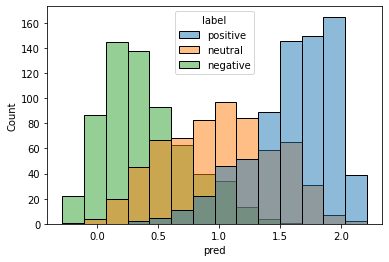

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

df_reg = pd.DataFrame({"label": y_val, "pred": xgb_linear_preds, "label_num": Y_val_scaled})

sns.histplot(data=df_reg, x="pred", hue="label")

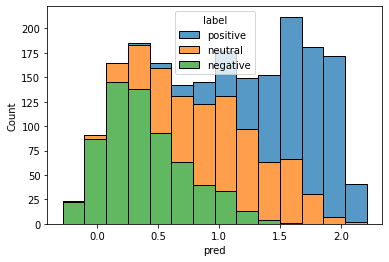

In [124]:
sns.histplot(data=df_reg, x="pred", hue="label", multiple="stack")

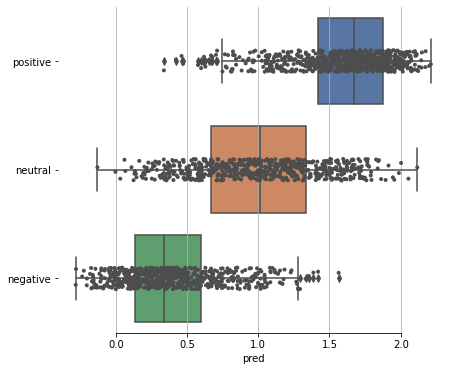

In [154]:
f, ax = plt.subplots(figsize=(7, 6))
sns.set_theme(style="ticks")
sns.boxplot(data=df_reg, x="pred", y="label")
# Add in points to show each observation
sns.stripplot(x="pred", y="label", data=df_reg,
              size=4, color=".3", linewidth=0)
# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [172]:
from scipy.optimize import minimize

def objective_function(x, y_hat, y_true):
  tsh0 = x[0]
  tsh1 = x[1]
  f_preds = []
  for pred in y_hat:
    if pred < tsh0:
      f_preds.append(0)
    elif pred > tsh1:
      f_preds.append(2)
    else:
      f_preds.append(1)

  return float(1-accuracy_score(y_true, f_preds))

#objective_function([0.4, 1.25], xgb_linear_preds, Y_val_scaled)

opt_reg = minimize(objective_function, [0.6, 1.25], args=(xgb_linear_preds, Y_val_scaled), method='nelder-mead')

opt_reg

 final_simplex: (array([[0.57864258, 1.32556152],
       [0.57865047, 1.32566118],
       [0.57872191, 1.32565701]]), array([0.2905, 0.2905, 0.2905]))
           fun: 0.2905
       message: 'Optimization terminated successfully.'
          nfev: 42
           nit: 17
        status: 0
       success: True
             x: array([0.57864258, 1.32556152])

In [173]:
opt_reg['x']

array([0.57864258, 1.32556152])

In [163]:
from scipy.optimize import minimize
res = minimize(
    objective_function,
    [0.1, 1.6],
    args=(xgb_linear_preds, Y_val_scaled),
    method='nelder-mead'
)
res

 final_simplex: (array([[0.67752594, 1.33331055],
       [0.67745906, 1.33330415],
       [0.67761531, 1.33330769]]), array([0.292, 0.292, 0.292]))
           fun: 0.29200000000000004
       message: 'Optimization terminated successfully.'
          nfev: 106
           nit: 47
        status: 0
       success: True
             x: array([0.67752594, 1.33331055])

### Simple Emsemble

In [51]:
nn_preds = learn.get_preds()[0]
nn_preds

tensor([[1.0959e-23, 2.6789e-01, 7.3211e-01],
        [2.8499e-12, 1.0000e+00, 1.4000e-15],
        [1.0000e+00, 1.2462e-18, 1.1471e-26],
        ...,
        [1.0000e+00, 2.4700e-16, 2.7459e-29],
        [7.0494e-01, 2.9506e-01, 1.9245e-11],
        [1.2818e-28, 2.7728e-11, 1.0000e+00]])

In [52]:
accuracy(tensor(nn_preds), tensor(to.valid.ys.values.ravel()))

TensorBase(0.7675)

In [64]:
skm.accuracy_score([clf_tabnet.classes_[item.argmax()] for item in tabnet_preds], y_val)

0.7545

In [54]:
skm.accuracy_score([xgb_model.classes_[item.argmax()] for item in xgb_preds], y_val)

0.7445

In [55]:
skm.accuracy_score([model_catb.classes_[item.argmax()] for item in catb_preds], y_val)

0.754

In [56]:
skm.accuracy_score([model_lgbm.classes_[item.argmax()] for item in lgbm_preds], y_val)

0.726

In [57]:
skm.accuracy_score([eclf_soft.classes_[item.argmax()] for item in eclf_soft_preds], y_val)

0.751

In [58]:
accuracy_score([le_scaler.classes_[item.argmax()] for item in svm_preds], le_scaler.inverse_transform(Y_val_scaled))

0.785

In [ ]:
#avgs = (nn_preds + xgb_preds + tabnet_preds + catb_preds + lgbm_preds + eclf_soft_preds) / 6
#avgs = (nn_preds + tabnet_preds + eclf_soft_preds) / 3
avgs = np.average([nn_preds, tabnet_preds, eclf_soft_preds, svm_preds], weights=[0.78, 0.7545, 0.7510, 0.79])
avgs

In [82]:
class_avg = [clf_tabnet.classes_[item.argmax()] for item in avgs.numpy()]

In [83]:
skm.accuracy_score(class_avg, y_val)

0.806

## Predict Test Set

In [63]:
#XGB
xgb_preds_final = xgb_model.predict_proba(X_test)

In [65]:
#Tabnet
tabnet_preds_final = clf_tabnet.predict_proba(X_test)

In [66]:
#NN Tabular
test_dl_df = dls.test_dl(df_test)
nn_preds_final = learn.get_preds(dl=test_dl_df)[0]

In [67]:
# LGBM
lgbm_preds_final = model_lgbm.predict_proba(X_test)

In [68]:
#CATBOOST
catb_preds_final = model_catb.predict_proba(X_test)

In [69]:
#ECFL
eclf_soft_preds_final = eclf_soft.predict_proba(X_test)

In [71]:
#SVM
X_test_scaled = scaler.transform(X_test)
svm_preds_final = svm_model.predict_proba(X_test_scaled)

In [84]:
#avgs_final = (nn_preds_final + tabnet_preds_final + eclf_soft_preds_final) / 3
avgs_final = np.average([nn_preds_final, tabnet_preds_final, eclf_soft_preds_final, svm_preds_final], weights=[0.78, 0.7545, 0.7510, 0.79])

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:377: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  a = np.asanyarray(a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)


In [85]:
class_avg_final = [clf_tabnet.classes_[item.argmax()] for item in avgs_final.numpy()]

In [ ]:
class_avg_final

## Generating Prediction File

In this starter kit we will directly be submitting the sample prediction file. In case you would like to see a submission via baseline model, check it out here. 

In [87]:
submission = pd.read_csv('data/sample_submission.csv')

In [88]:
submission['label'] = class_avg_final

In [89]:
import datetime 

current_date = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
name = "ensemble_tablearn_tabnet_eclf_catb_xgb_lgbm_svm"
submission.to_csv(f"/content/drive/MyDrive/models/face-sentiment-embbedings/submission_{name}_{current_date}.csv", index = False)

In [90]:
!rm -rf assets
!mkdir assets
submission.to_csv(os.path.join("assets", "submission.csv"))


# Submitting our Predictions

Note : Please save the notebook before submitting it (Ctrl + S)


In [91]:
%aicrowd notebook submit -c sentiment-classification -a assets --no-verify

Using notebook: Cópia de Cópia de Getting Starter Notebook for Sentiment Classification  for submission...
Scrubbing API keys from the notebook...


Output()

╭─────────────────────────╮                                                       
                                                       │ Successfully submitted! │                                                       
                                                       ╰─────────────────────────╯

                                                             Important links                                                             
┌──────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/sentiment-classification/submissions/175504              │
│                  │                                                                                                                    │
│  All submissions │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/sentiment-classification/submissions?my_submissions=true │
│                  │                                                                                                                    │
│      Leaderboard │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/sentiment-classification/leaderboards                    │
│                  │                                                                                                                    │
│ Discussion forum │ https://discourse.aicrowd.com/c/ai-blitz-xiii                                                                      │
│                  │                                                                                                                    │
│   Challenge page │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/sentiment-classification                                 │
└──────────────────┴────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘